# GLM

By Charles Xu @ DJA Lab, Caltech

## Set up environment

In [1]:
# Import packages
# import sys; sys.path.insert(0, r'/Users/alveus/Documents/WorkingDirectory/Packages/Python')
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.io as sio

import statsmodels.api as sm

from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# import ssm
# from ssm.util import find_permutation

In [44]:
# User inputs
# data_path = r'/Users/alveus/Documents/WorkingDirectory/Data/DJA/Jineun/EG1-4/neural_male/EG1-4-fasted-0629-regis from fed male_neural_behavior_py.mat' # Path to data on my Mac
data_path = r'D:\DJA\Jineun\EG1-4\neural_male\EG1-4-fasted-0629-regis from fed male_neural_behavior_py.mat' # Path to data on my PC
time_window = 5 # Time window for regressors (in seconds)
frame_rate = 10 # Frame rate of the data (in Hz)
time_step = 5 # Time step for the regressors (in seconds)
n_folds = 5 # Number of folds for cross-validation
# neuron_idx = 8 # Index of neuron to plot
good_beta_threshold = 0.5 # Threshold for good betas as a proportion of the maximum beta

In [3]:
# Load data
mat = sio.loadmat(data_path)
x_raw = mat['behaviorFullMaFPS']
y = np.array(mat['neural_ref']).T
label_raw = mat['behaviorNames']
labels = []
for i in range(len(label_raw)):
    labels.append(label_raw[i][0][0])

## Processing data

In [4]:
# Function: design matrix
def design_matrix(data, time_window, frame_rate, time_step):
    """
    data: behavior data
    time_window: time window for design matrix (plus or minus)
    frame_rate: frame rate of data
    """
    num_rows = data.shape[0]
    num_shifts = int(time_window * frame_rate // time_step)
    design_matrix = np.zeros((num_rows*(2*num_shifts+1), data.shape[1]))

    for i in range(num_rows):
        for j in range(-time_window*frame_rate, time_window*frame_rate+1, time_step):
            if j == 0:
                design_matrix[i*(num_shifts+1)+j+num_shifts, :] = data[i,:]
            elif j < 0:
                design_matrix[i*(num_shifts+1)+j+num_shifts, 0:j] = data[i,-j:]
            else:
                design_matrix[i*(num_shifts+1)+j+num_shifts, j:] = data[i,0:-j]
    return design_matrix

x = design_matrix(x_raw, time_window, frame_rate, time_step).T
xd = x.shape[1]
yd = y.shape[1]
tt = x.shape[0]
print(f'Dimensions of x: {xd}')
print(f'Dimensions of y: {yd}')
print(f'Total time points: {tt}')

Dimensions of x: 273
Dimensions of y: 73
Total time points: 14759


### Normalization / z-score

<font color='red'>Normalization vs z-score? (at least not for binary task variables)</font>

In [5]:
# Min-max normalization
# x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0)) # normalize columns of x
# y = (y - np.min(y, axis=0)) / (np.max(y, axis=0) - np.min(y, axis=0)) # normalize columns of y

# Mean center y
y = y - np.mean(y, axis=0)

## Fit GLMs

In [6]:
# Set up k-fold cross-validation
kf = KFold(n_splits=n_folds, shuffle=True) # Initialize KFold object

### Fit using simple linear regression

In [7]:
# # Function: linear regression using OLS
# def ols(x,y):
#     """
#     x: design matrix
#     y: neural data
#     """
#     betas = np.linalg.inv(x.T @ x) @ x.T @ y # the @ symbol is equivalent to np.matmul()
#     return betas

In [8]:
# # Function: R-squared
# def r_squared(y_true, y_pred):
#     """
#     y_true: true value
#     y_pred: predicted value
#     """
#     r_squared = 1-np.sum((y_true-y_pred)**2)/np.sum((y_true-np.mean(y_true))**2)
#     return r_squared

In [9]:
# Fit linear regression model
linreg = linear_model.LinearRegression()

betas_lin = np.zeros((yd, xd, n_folds)) # Initialize betas matrix
r2_lin = np.zeros((yd, n_folds)) # Initialize r2 matrix

for i, (train_index, test_index) in enumerate(kf.split(x)): # Loop through folds
    x_train, x_test = x[train_index], x[test_index] # Split x into train and test sets
    y_train, y_test = y[train_index], y[test_index] # Split y into train and test sets

    linreg.fit(x_train, y_train) # Fit ridge regression model
    betas_lin[:,:,i] = linreg.coef_ # Store betas

    y_pred = linreg.predict(x_test) # Predict y
    r2_lin[:,i] = r2_score(y_test, y_pred, multioutput='raw_values') # Calculate R2

betas_lin = np.mean(betas_lin, axis=2) # Average betas across folds
r2_lin = np.mean(r2_lin, axis=1) # Average R2 across folds


In [10]:
# # Print beta weights for each behavior
# for label, beta in zip(labels, betas):
#     print(f'OLS beta weight for {label}: {len(beta)}')

### Fit using ridge regression which penalizes $\beta$ by $L_2$ regularization

#### Determine the best complexity parameter, $\alpha$, using grid search CV

In [11]:
# Set up grid search CV
alpha_test_range = 10**np.linspace(-10,9,50) # Get search values for alpha on log scale

fit_intercept = False # If y is mean-centered, set to False
alpha_per_target = True # Allow every neuron to be regularized individualy for better model performance

# Perform grid search CV using RidgeCV
ridge_grid_search = linear_model.RidgeCV(alphas=alpha_test_range, fit_intercept=fit_intercept, scoring='r2', store_cv_values=True, alpha_per_target=alpha_per_target)
ridge_grid_search.fit(x,y)
alphas = ridge_grid_search.alpha_

Text(0, 0.5, 'Count')

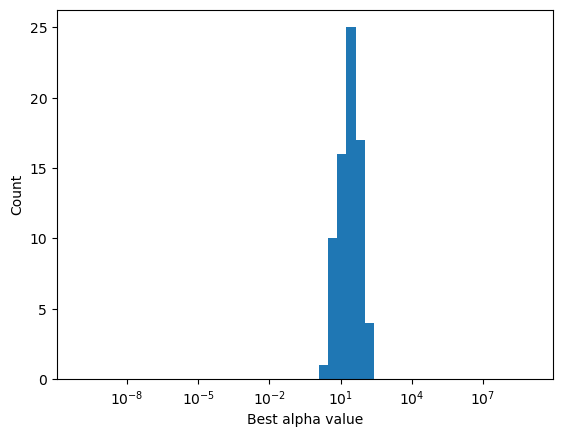

In [34]:
# Distribution of best alphas
fig,ax = plt.subplots()
ax.hist(alphas, bins=alpha_test_range)
ax.set_xscale('log')
ax.set_xlabel('Best alpha value')
ax.set_ylabel('Count')

#### Fit ridge regression

In [12]:
# Fit ridge regression model
ridgereg = linear_model.Ridge(alpha=alphas, fit_intercept=fit_intercept) # Initialize Ridge object

betas_ridge = np.zeros((yd, xd, n_folds)) # Initialize betas matrix
r2_ridge = np.zeros((yd, n_folds)) # Initialize r2 matrix

for i, (train_index, test_index) in enumerate(kf.split(x)): # Loop through folds
    x_train, x_test = x[train_index], x[test_index] # Split x into train and test sets
    y_train, y_test = y[train_index], y[test_index] # Split y into train and test sets

    ridgereg.fit(x_train, y_train) # Fit ridge regression model
    betas_ridge[:,:,i] = ridgereg.coef_ # Store betas

    y_pred = ridgereg.predict(x_test) # Predict y
    r2_ridge[:,i] = r2_score(y_test, y_pred, multioutput='raw_values') # Calculate R2

betas_ridge = np.mean(betas_ridge, axis=2) # Average betas across folds
r2_ridge = np.mean(r2_ridge, axis=1) # Average R2 across folds

In [13]:
# for i, (train_index, test_index) in enumerate(kf.split(x)): # Loop through folds
#     print(i, train_index, test_index)

### Fit using LASSO regression which penalizes $\beta$ by $L_1$ regularization

(73, 273)

## Assess model performance

### Cross-validated R-squared score

Best R² using OLS: 0.5652744338191803
Best fit neuron using ridge regression: 59


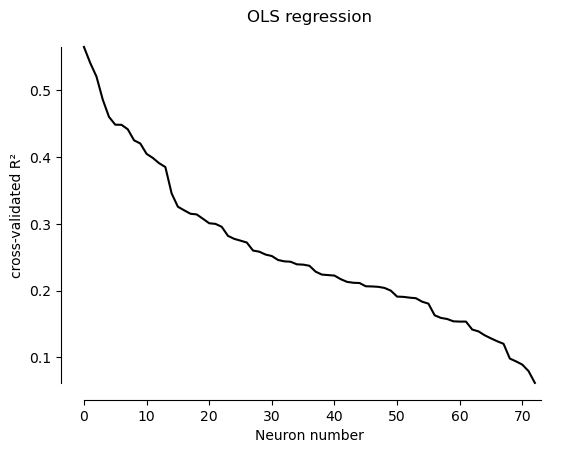

In [76]:
# Plot R-squared for each neuron using OLS
idx_lin = np.argsort(r2_lin)[::-1]

ax = plt.figure().add_subplot(111)
ax.plot(r2_lin[idx_lin], color = 'k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds([min(r2_lin),max(r2_lin)])
ax.spines['bottom'].set_bounds([0,yd])
ax.set_title('OLS regression')
ax.set_xlabel('Neuron number')
ax.set_ylabel('cross-validated R\u00b2')

# Print best R-squared obtained using OLS
best_r2_lin = max(r2_lin)
best_fit_neuron_lin = np.argmax(r2_lin)
print(f'Best R\u00b2 using OLS: {best_r2_lin}')
print(f'Best fit neuron using ridge regression: {best_fit_neuron_lin}')

Best R² using ridge regression: 0.5043491944493634
Best fit neuron using ridge regression: 59
Corresponding alpha: 2.9470517025518097


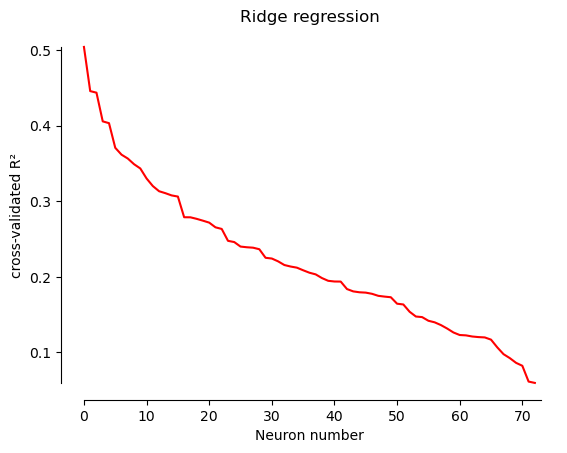

In [75]:
# Plot R-squared for each neuron using ridge regression
idx_ridge = np.argsort(r2_ridge)[::-1]

ax = plt.figure().add_subplot(111)
ax.plot(r2_ridge[idx_ridge], color = 'r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds([min(r2_ridge),max(r2_ridge)])
ax.spines['bottom'].set_bounds([0,yd])
ax.set_title('Ridge regression')
ax.set_xlabel('Neuron number')
ax.set_ylabel('cross-validated R\u00b2')

# Print best R-squared obtained using ridge regression and corresponding alpha
best_r2_ridge = max(r2_ridge)
best_fit_neuron_ridge = np.argmax(r2_ridge)
print(f'Best R\u00b2 using ridge regression: {best_r2_ridge}')
print(f'Best fit neuron using ridge regression: {best_fit_neuron_ridge}')
print(f'Corresponding alpha: {alphas[np.argmax(r2_ridge)]}')

### Beta weights for regressors

In [39]:
# Separate betas according to labels
betas_lin_labeled = {}
betas_ridge_labeled = {}
num_labels = len(labels)

for i in range(num_labels):
    betas_lin_labeled[labels[i]] = betas_lin[:, i*xd//num_labels:(i+1)*xd//num_labels]
    betas_ridge_labeled[labels[i]] = betas_ridge[:, i*xd//num_labels:(i+1)*xd//num_labels]

# The resulting `betas_lin_labeled` dictionary will have keys corresponding to the labels in `label`, and values corresponding to the corresponding subset of columns in `xd` divided by the number of labels of columns in beta, from left to right.

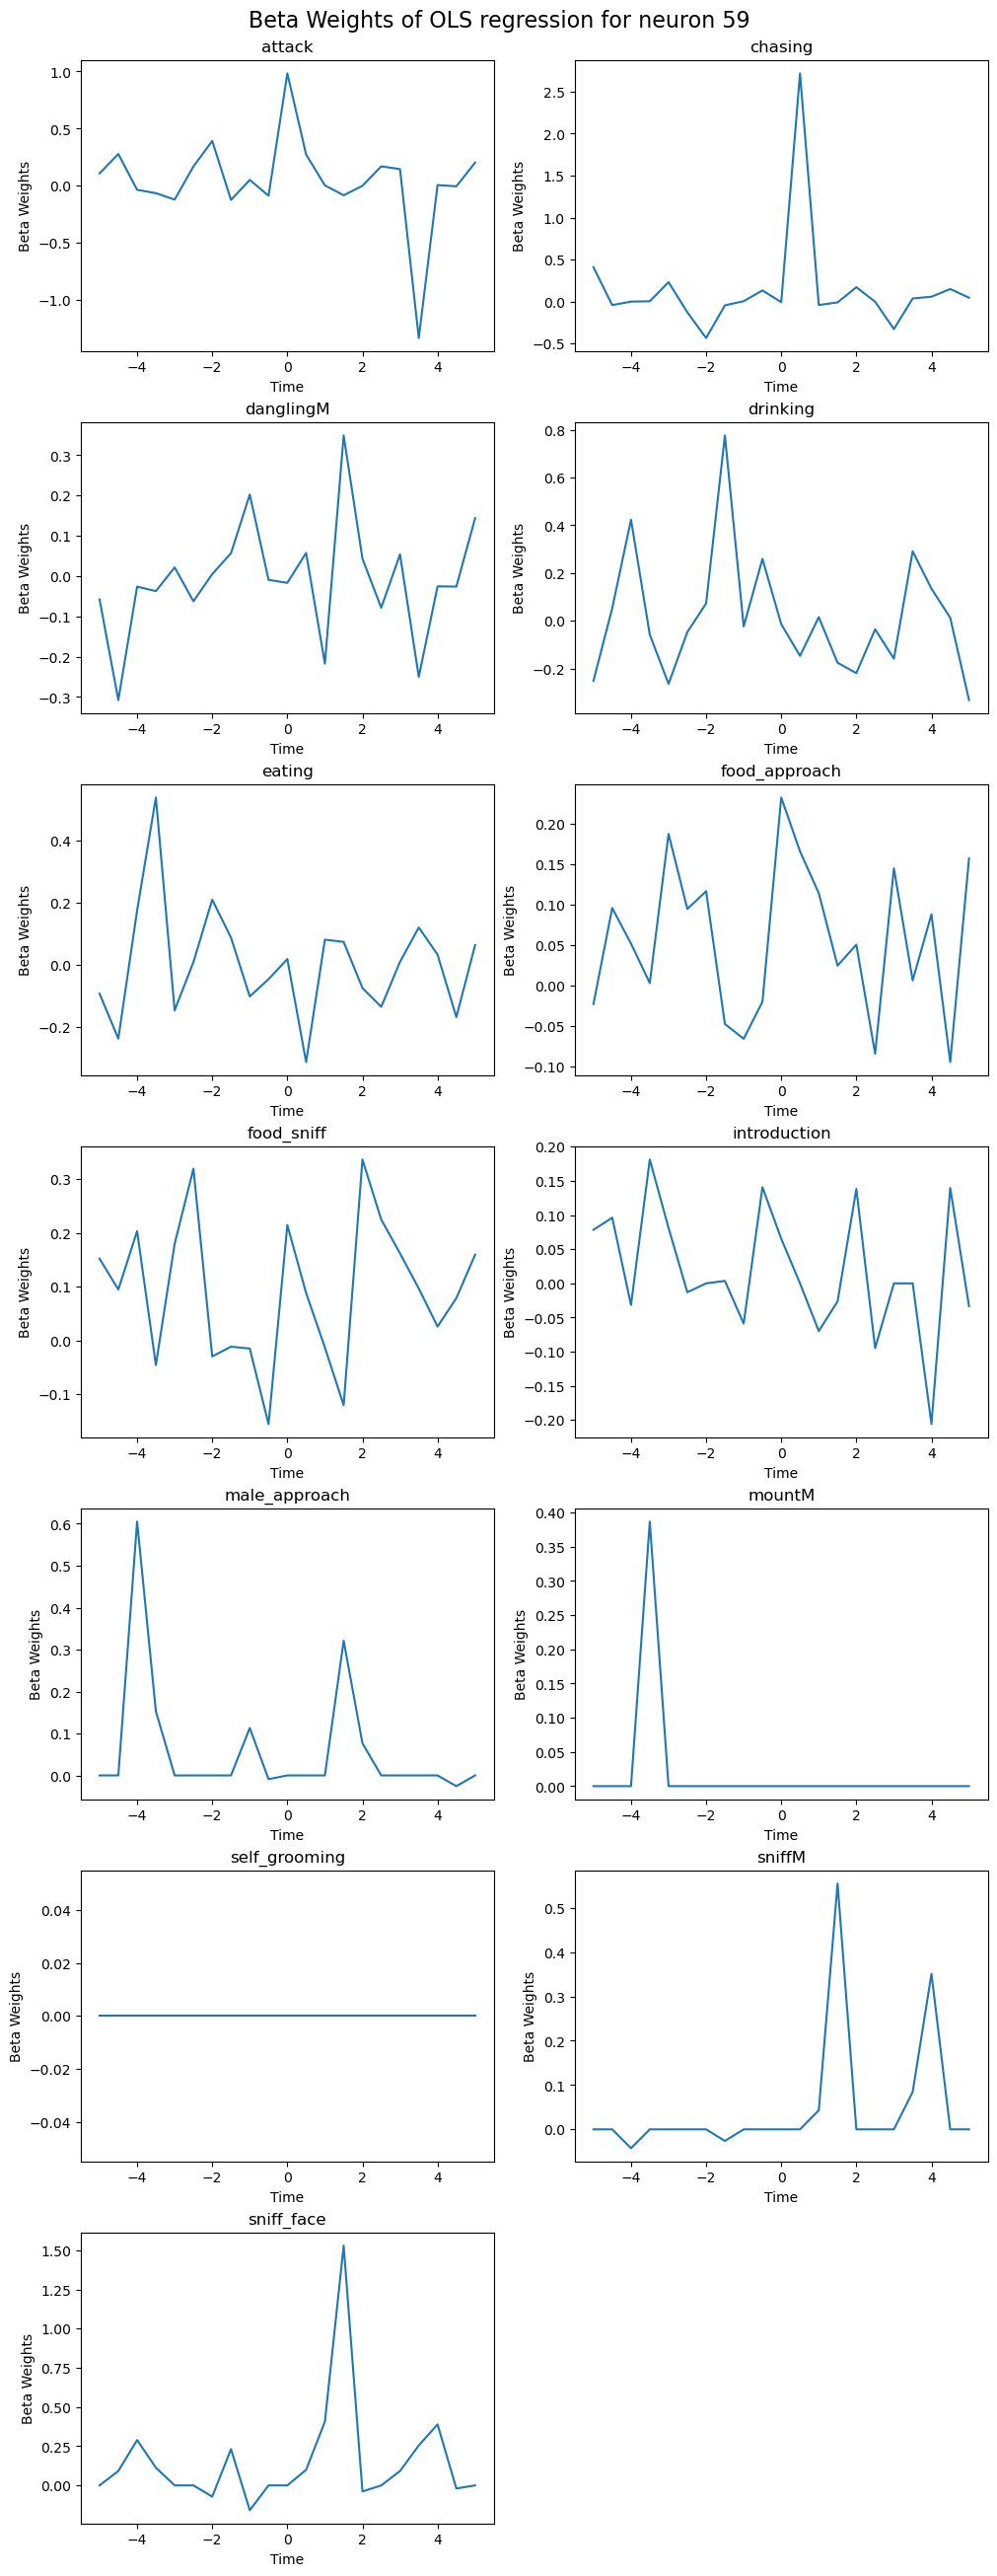

In [79]:
# Plot betas for each behavior using OLS
num_labels = len(labels)

fig, axs = plt.subplots(nrows=np.ceil(num_labels/2).astype(int), ncols=2, figsize=(10, 4*num_labels//2), constrained_layout=True)

for i in range(num_labels):
    row = i // 2
    col = i % 2
    axs[row, col].plot(np.arange(-time_window*frame_rate, time_window*frame_rate+1, time_step)/10, betas_lin_labeled[labels[i]][best_fit_neuron_lin, :])
    axs[row, col].set_title(labels[i])
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Beta Weights')

    if i == num_labels - 1 and num_labels % 2 == 1:
        axs[row, col+1].axis('off')

fig.suptitle('Beta Weights of OLS regression for neuron {}'.format(best_fit_neuron_lin), fontsize=16)
plt.show()

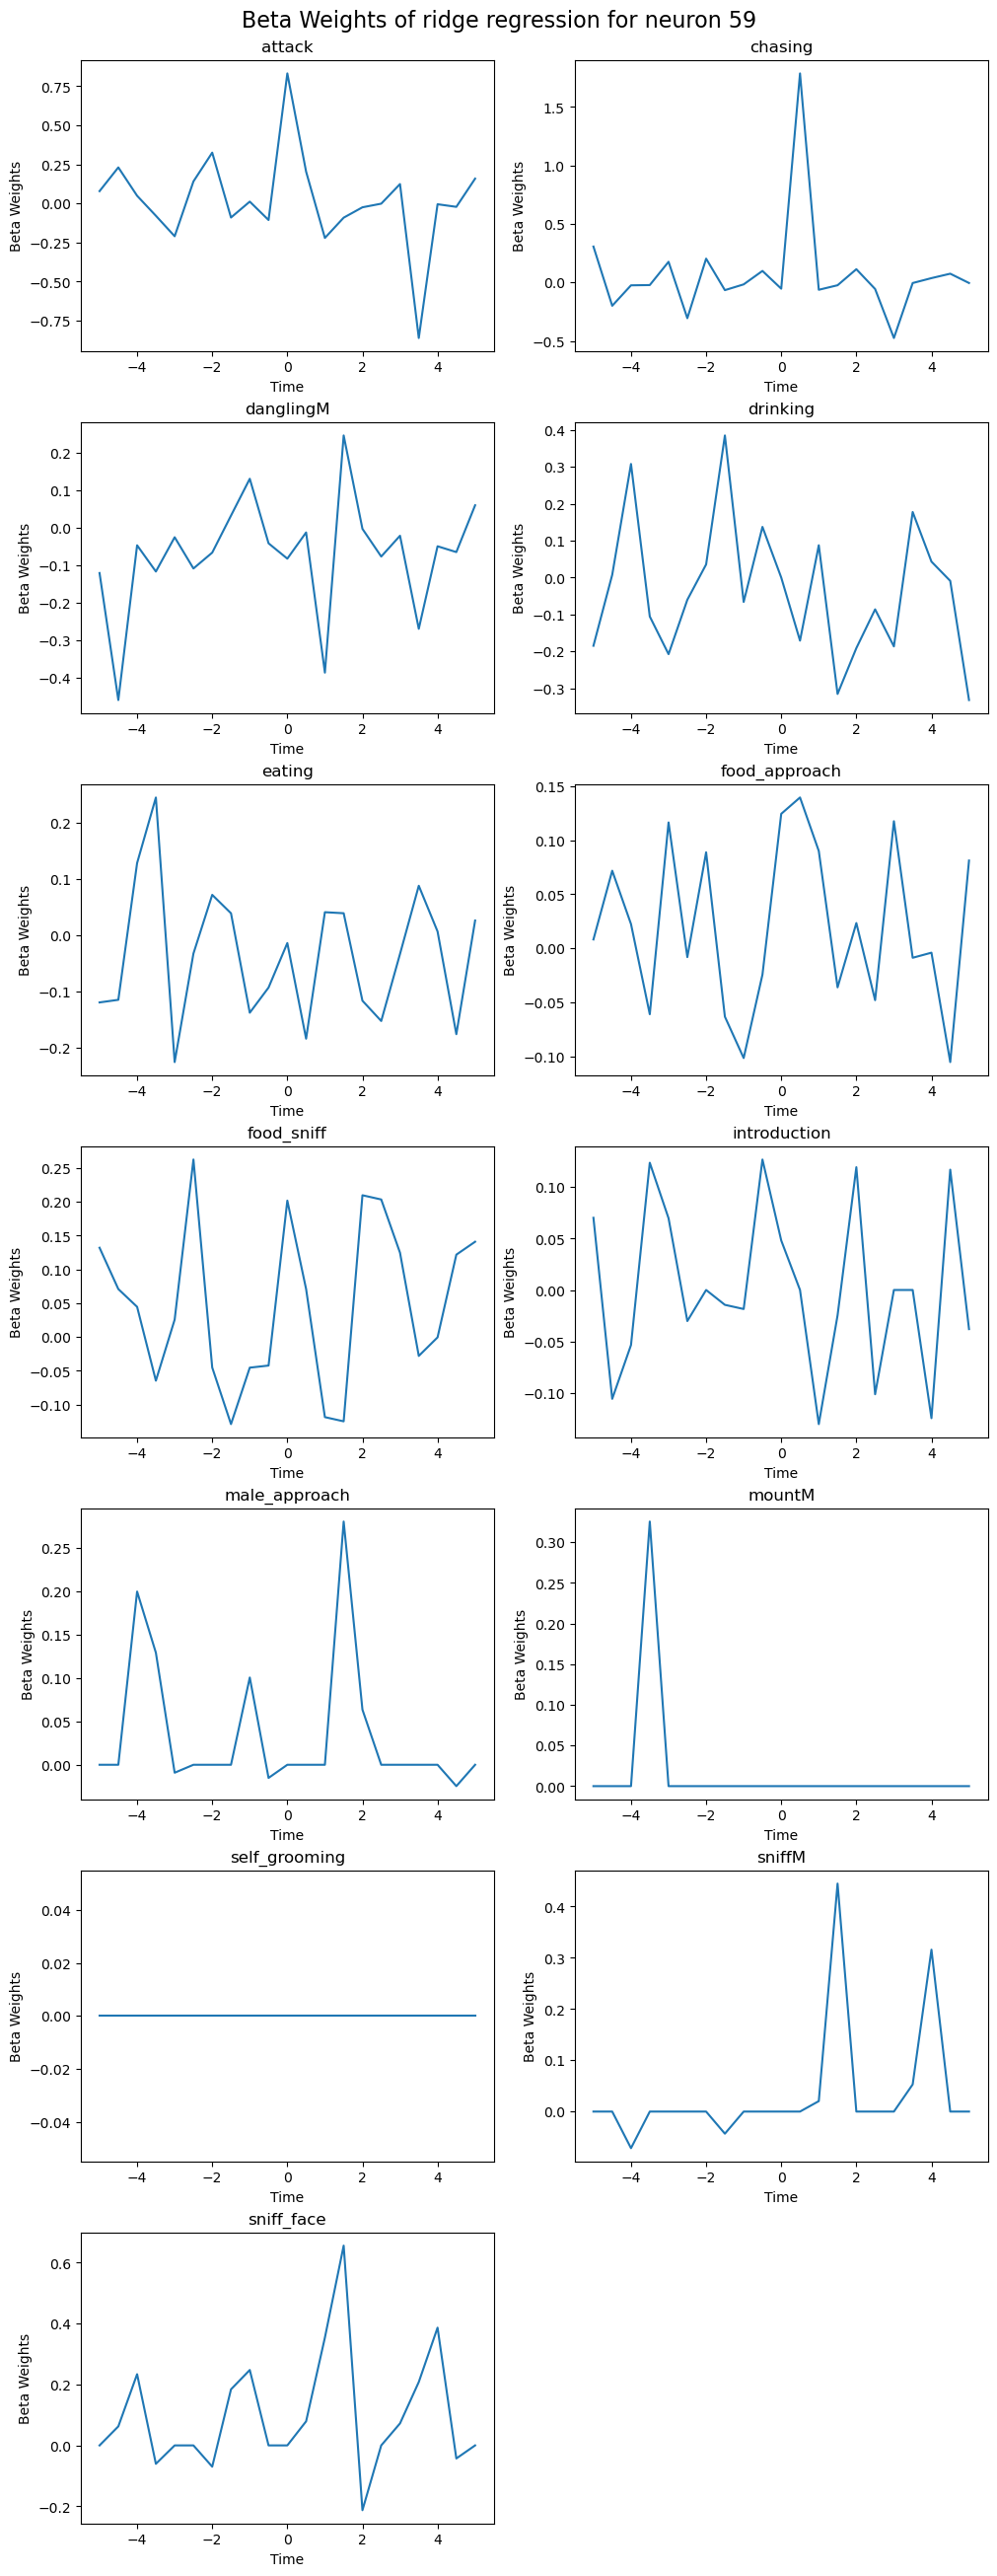

In [80]:
# Plot betas for each behavior using ridge regression (for the best fit neuron from ridge regression)
fig, axs = plt.subplots(nrows=np.ceil(num_labels/2).astype(int), ncols=2, figsize=(10, 4*num_labels//2), constrained_layout=True)

for i in range(num_labels):
    row = i // 2
    col = i % 2

    axs[row, col].plot(np.arange(-time_window*frame_rate, time_window*frame_rate+1, time_step)/10, betas_ridge_labeled[labels[i]][best_fit_neuron_ridge, :])
    axs[row, col].set_title(labels[i])
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Beta Weights')

    if i == num_labels - 1 and num_labels % 2 == 1:
        axs[row, col+1].axis('off')

fig.suptitle('Beta Weights of ridge regression for neuron {}'.format(best_fit_neuron_ridge), fontsize=16)
plt.show()

### Select good fit neurons

In [71]:
# Select neurons with good fits (from OLS)
good_fit_neuron_lin = np.where(r2_lin > np.max(r2_lin)*good_beta_threshold)[0]

# Select neurons with good fits (from ridge regression)
good_fit_neuron_ridge = np.where(r2_ridge > np.max(r2_ridge)*good_beta_threshold)[0]


array([ 6,  7,  8, 13, 14, 16, 21, 22, 24, 26, 34, 35, 36, 37, 45, 53, 54,
       55, 57, 58, 59, 64, 65], dtype=int64)

### Model prediction

Plot model prediction compared actual neural data

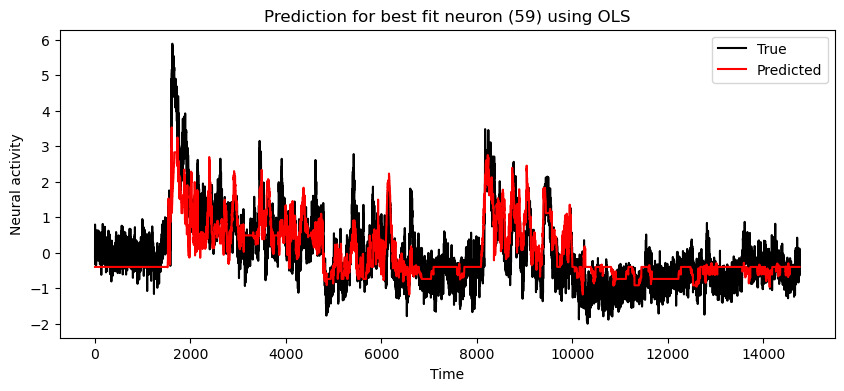

In [88]:
# Plot prediction for best fit neuron using OLS
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y[:,best_fit_neuron_lin], color='k', label='True')
ax.plot(linreg.predict(x)[:,best_fit_neuron_lin], color='r', label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Neural activity')
ax.set_title(f'Prediction for best fit neuron ({best_fit_neuron_lin}) using OLS')
ax.legend()

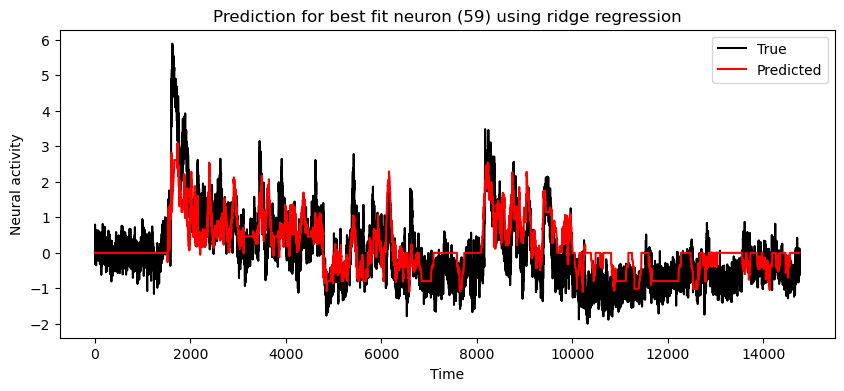

In [87]:
# Plot prediction for best fit neuron using ridge regression
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y[:,best_fit_neuron_ridge], color='k', label='True')
ax.plot(ridgereg.predict(x)[:,best_fit_neuron_ridge], color='r', label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Neural activity')
ax.set_title(f'Prediction for best fit neuron ({best_fit_neuron_ridge}) using ridge regression')
ax.legend()

## EDA

### Cluster beta weights

In [93]:
betas_ridge.shape

(73, 273)